In this notebook, we want to summarize the data and make sure that it is behaving as we expect based on previous literature. Here, we want to only use the outcome for tumor_cell_evaluation

Tumor score is defined by UCSF pathologists in the following way: <br>

0: neuropil without tumor <br>
1: infiltrating tumor margin containing a detectable but not abundant number of tumor cells <br>
2: more cellular infiltrated zone <br>
3: highly cellular tumor <br>

In [1]:
recgli = read.csv("../../ParseData/7thParse_researchPath_withInVivo.csv") 

#### In this notebook, we want to find: <br>
1. Diffusion params vs. TS using <br>
    a. No separation into ROIs <br>
    b. Visual comparison of anatomical params in separate regions <br>
    ~~c. Repeated Measures ANOVA (analysis of variance) to account for multiple samples from the same patient to see if there is true separation among tumor scores for diffusion parameters~~ <b> you can't use RMANOVA for categorical data </b> (sources: http://sherifsoliman.com/2014/12/10/ANOVA_in_R/, https://www.r-bloggers.com/two-way-anova-with-repeated-measures/, https://www.r-statistics.com/tag/ezanova/) <br> 
    c. Use GLMM associate diffusion parameters with TS, no separation <br>
    d. Use GEE to associate diffusion parameters with TS, no separation <br>
    e. Use GLMM to associate diffusion parameters with TS, separating into CEL & NEL <br>
    f. Use GEE to associate diffusion parameters with TS, separating into CEL & NEL <br>
2. Combining diffu params vs. TS using GEE 
3. Using in_CEL as a covariate in anat params using GEE 

## 0. Prep the data

In [2]:
recgli = recgli[recgli$tumor_cell_evaluation != "Ind",]
dim(recgli)
recgli = droplevels(recgli)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
str(recgli$tumor_cell_evaluation)
colnames(recgli)

[1] 423  75

 num [1:423] 0 2 2 2 0 1 0 2 1 0 ...


[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nt1d"                     
[21] "nadc.1"                    "nfa.1"                    
[23] "nev1.1"                    "nev2.1"                   
[25] "nev3.1"                    "nevrad.1"                 
[27] "nadc.2"                    "nfa.2"                    
[29] "nev1.2"                    "nev2.2"                   
[31] "nev3.2"                    "nevrad.2"                 
[33] "cbvn_nlin"                 "phn_nlin"                 
[35] "phn_npar"                  "recovn_npar"              
[37] "cni"                       "ccri"                     
[39] "crni"                      "ncho"                     
[41] "ncre"                      "nnaa"                     
[43] "laclip"                    "nlip"                     
[45] "nlac"                      "olddata"                  
[47] "newdata"                   "comments"                 
[49] "notes."                    "imaging_code"             
[51] "perf_quant"                "cbv_nlin"                 
[53] "spec_quant"                "include_anat"             
[55] "include_diffu1000"         "include_diffu2000"        
[57] "include_diffu_all"         "include_perf"             
[59] "include_spec"              "include_one_advanced_mod" 
[61] "include_all_advanced_mods" "X.CEL"                    
[63] "X.NEL"                     "X.NEC"                    
[65] "sum"                       "in_CEL"                   
[67] "in_T2all"                  "in_NEL"                   
[69] "in_NEC"                    "in_ROI"                   
[71] "desired_hist"              "multnom_out"              
[73] "no_ffpe"                   "waiting_on_path"          
[75] "rhgg_txe_analysis"

In [3]:
recgli.diffu = recgli[recgli$include_diffu_all==1,]
dim(recgli.diffu)

[1] 415  75

In [4]:
recgli = recgli.diffu 

In [5]:
recgli$t_number = as.factor(recgli$t_number)
#str(recgli)

In [15]:
table(recgli$in_NEC)


  0   1 
394  21 

## 1. Diffusion (b= 1000) vs. TS 

### a. No separation into ROIs

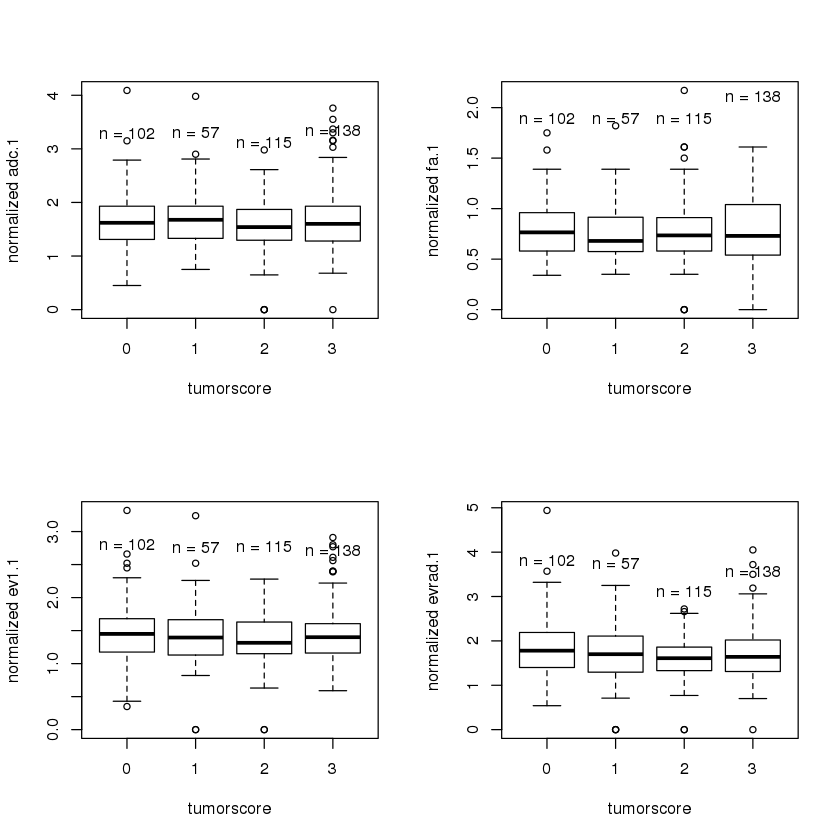

In [7]:
par(mfrow = c(2, 2))
a = boxplot(nadc.1 ~ tumor_cell_evaluation , data = recgli, ylab = "normalized adc.1", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

b = boxplot(nfa.1 ~ tumor_cell_evaluation , data = recgli, ylab = "normalized fa.1", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

c = boxplot(nev1.1 ~ tumor_cell_evaluation , data = recgli, ylab = "normalized ev1.1", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

d = boxplot(nevrad.1 ~ tumor_cell_evaluation , data = recgli, ylab = "normalized evrad.1", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )


### b. CEL next to NEL scores  


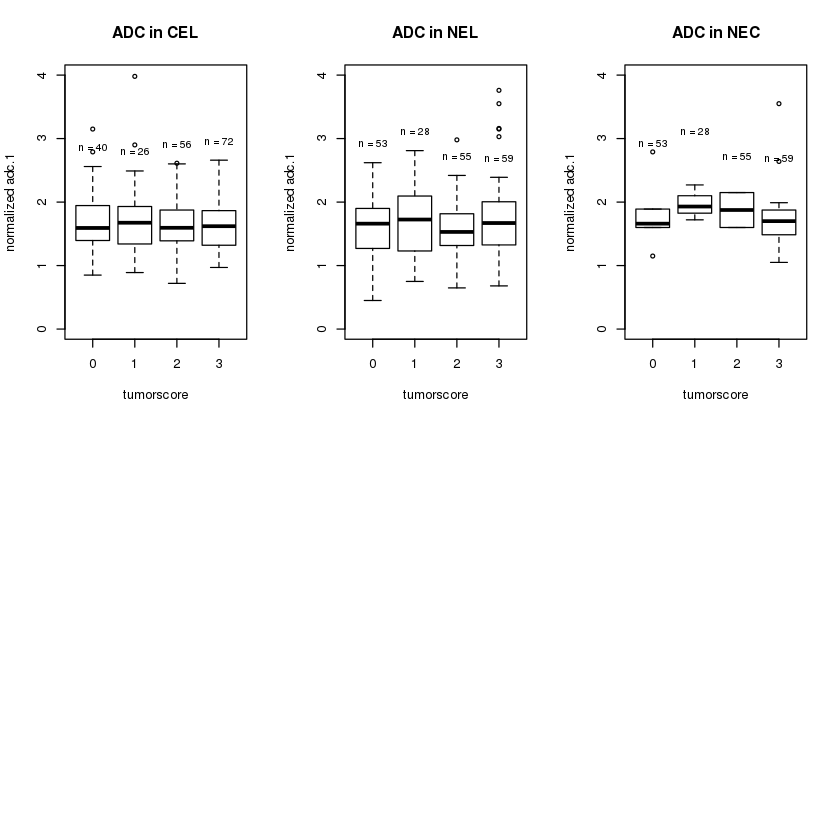

In [14]:
par(mfrow = c(2, 3))
a = boxplot(nadc.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized adc.1", xlab = "tumorscore", main = "ADC in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

b = boxplot(nadc.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized adc.1", xlab = "tumorscore", main = "ADC in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

c = boxplot(nadc.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEC ==1,], ylab = "normalized adc.1", xlab = "tumorscore", main = "ADC in NEC", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)




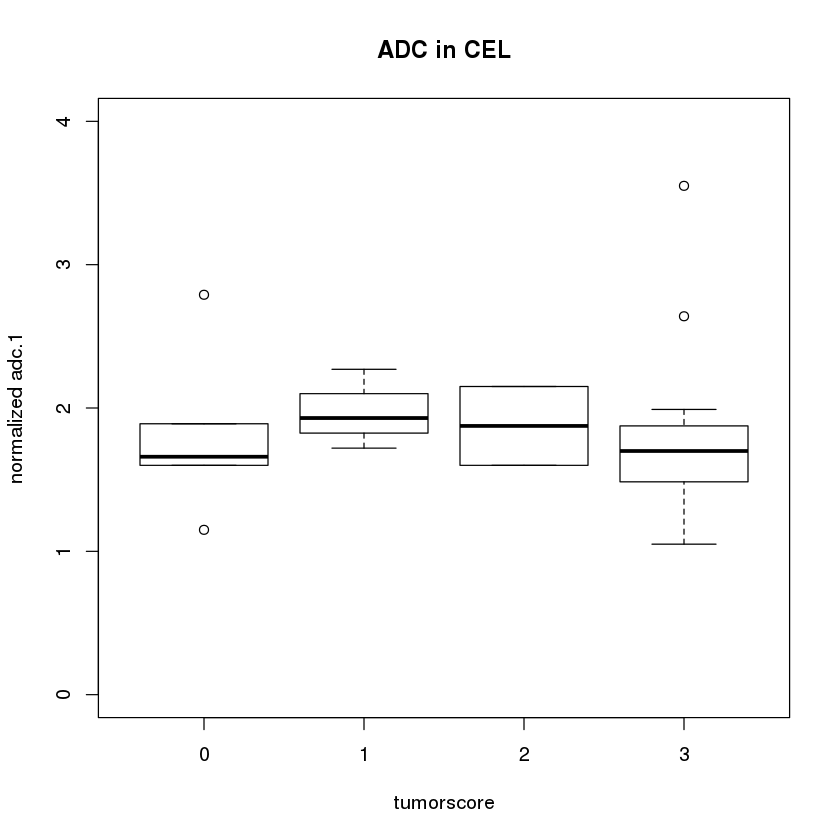

In [24]:
a = boxplot(nadc.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEC ==1,], ylab = "normalized adc.1", xlab = "tumorscore", main = "ADC in CEL", ylim = c(0,4))


In [ ]:
c = boxplot(nfa.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized fa.1", xlab = "tumorscore", main = "FA in CEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)
d = boxplot(nfa.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized fa", xlab = "tumorscore", main = "FA in NEL", ylim = c(0,3.5))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(nev1.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized ev1.1", xlab = "tumorscore", main = "EV1 in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(nev1.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized ev1.1", xlab = "tumorscore", main = "EV1 in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

g = boxplot(nevrad.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized evrad.1", xlab = "tumorscore", main = "EVRAD in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , g$stats[nrow(g$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
h = boxplot(nevrad.1 ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized evrad.1", xlab = "tumorscore", main = "EVRAD in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , h$stats[nrow(h$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)


### c. Use GLMM associate diffu parameters with TS, no separation 

In [9]:
## I will come back to this later. 

### d. Use GEE to associate diffu parameters with TS, no separation

In [11]:
library(glmnet)
library(geepack)
library(lme4)
#install.packages("multgee")
library("multgee")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gnm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines

Attaching package: ‘VGAM’

The following object is masked from ‘package:mlogit’:

    lrtest



In [12]:
nadc.fit = ordLORgee(formula = tumor_cell_evaluation ~ nadc.1, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nadc.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-0.91188,0.33641,-2.71062,0.00672
beta20,-0.25897,0.32700,-0.79195,0.42839
beta30,1.00482,0.33082,3.03738,0.00239
nadc.1,-0.17137,0.18182,-0.94249,0.34594


In [13]:
nfa.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfa.1, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch", bstart = summary(nadc.fit)$coefficients[,1])
summary(nfa.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.27252,0.46946,-2.71058,0.00672
beta20,-0.62079,0.47020,-1.32028,0.18674
beta30,0.54230,0.33711,1.60865,0.10769
nfa.1,0.18002,0.33716,0.53393,0.59339


In [14]:
nev1.fit = ordLORgee(formula = tumor_cell_evaluation ~ nev1.1, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nev1.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.03998,0.39557,-2.62906,0.00856
beta20,-0.35200,0.39153,-0.89902,0.36864
beta30,0.79214,0.38990,2.03166,0.04219
nev1.1,-0.07832,0.25609,-0.30583,0.75974


In [15]:
nevrad.fit = ordLORgee(formula = tumor_cell_evaluation ~ nevrad.1, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(nevrad.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.02623,0.34115,-3.00814,0.00263
beta20,-0.33866,0.33612,-1.00755,0.31367
beta30,0.80427,0.33722,2.38504,0.01708
nevrad.1,-0.07361,0.18148,-0.40560,0.68503


### e. Use GLMM to associate anatomical parameters with TS, separating into CEL & NEL 

In [16]:
## need to come back to when becomes more obvious how to do GLMM with multinomial outcome... 
##can do this using a one-v-all method 
library(mlogit)

In [17]:
data_mlog <-mlogit.data(recgli,  id.var ="t_number", shape="wide", 
                        sep="", varying=NULL, 
                       choice = "tumor_cell_evaluation")

In [19]:
mlogit_nadc.1 <- mlogit(tumor_cell_evaluation ~1 | nadc.1, data=data_mlog)
summary(mlogit_nadc.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nadc.1, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.23467 0.14133 0.30133 0.32267 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.000989 
successive function values within tolerance limits 

Coefficients :
                Estimate Std. Error z-value Pr(>|z|)  
1:(intercept) -0.5136558  0.5493238 -0.9351  0.34975  
2:(intercept)  0.9820779  0.4554066  2.1565  0.03105 *
3:(intercept)  0.3097094  0.4426328  0.6997  0.48412  
1:nadc.1       0.0039183  0.3084575  0.0127  0.98986  
2:nadc.1      -0.4515157  0.2659119 -1.6980  0.08951 .
3:nadc.1       0.0051762  0.2485613  0.0208  0.98339  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -501.36
McFadden R^2:  0.0046018 
Likelihood ratio test : chisq = 4.6357 (p.value = 0.20051)

In [21]:
mlogit_nfa.1 <- mlogit(tumor_cell_evaluation ~1 | nfa.1, data=data_mlog)
summary(mlogit_nfa.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nfa.1, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.23889 0.14167 0.29444 0.32500 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 2.06E-08 
gradient close to zero 

Coefficients :
               Estimate Std. Error z-value Pr(>|z|)
1:(intercept) -0.050907   0.486605 -0.1046   0.9167
2:(intercept)  0.647087   0.400463  1.6158   0.1061
3:(intercept)  0.399249   0.391170  1.0207   0.3074
1:nfa.1       -0.592476   0.575264 -1.0299   0.3030
2:nfa.1       -0.548811   0.466426 -1.1766   0.2393
3:nfa.1       -0.111546   0.444244 -0.2511   0.8017

Log-Likelihood: -482.81
McFadden R^2:  0.0022529 
Likelihood ratio test : chisq = 2.1804 (p.value = 0.53582)

In [20]:
mlogit_ev1.1 <- mlogit(tumor_cell_evaluation ~1 | nev1.1, data=data_mlog)
summary(mlogit_ev1.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nev1.1, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24179 0.14328 0.27463 0.34030 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.000589 
successive function values within tolerance limits 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)  
1:(intercept)  0.15818    0.63804  0.2479  0.80420  
2:(intercept)  1.12983    0.53862  2.0976  0.03594 *
3:(intercept)  0.49135    0.50361  0.9757  0.32923  
1:nev1.1      -0.47403    0.42904 -1.1049  0.26922  
2:nev1.1      -0.70762    0.36423 -1.9428  0.05204 .
3:nev1.1      -0.10160    0.32711 -0.3106  0.75611  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -447.51
McFadden R^2:  0.0056012 
Likelihood ratio test : chisq = 5.0415 (p.value = 0.16878)

In [22]:
mlogit_evrad.1 <- mlogit(tumor_cell_evaluation ~1 | nevrad.1, data=data_mlog)
summary(mlogit_evrad.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nevrad.1, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24179 0.14328 0.27463 0.34030 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.000819 
successive function values within tolerance limits 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)  
1:(intercept)  0.20632    0.55000  0.3751  0.70756  
2:(intercept)  1.10393    0.46483  2.3749  0.01755 *
3:(intercept)  0.67331    0.43260  1.5564  0.11960  
1:nevrad.1    -0.42155    0.30396 -1.3869  0.16548  
2:nevrad.1    -0.57322    0.25770 -2.2244  0.02612 *
3:nevrad.1    -0.18679    0.22888 -0.8161  0.41443  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -447.14
McFadden R^2:  0.0064334 
Likelihood ratio test : chisq = 5.7905 (p.value = 0.12226)

In [26]:
mlogit_nadc.2 <- mlogit(tumor_cell_evaluation ~1 | nadc.2, data=data_mlog)
summary(mlogit_nadc.2)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nadc.2, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.20755 0.13208 0.32075 0.33962 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 3.46E-07 
gradient close to zero 

Coefficients :
               Estimate Std. Error z-value Pr(>|z|)  
1:(intercept) -1.645718   0.825548 -1.9935  0.04621 *
2:(intercept)  0.493855   0.659351  0.7490  0.45386  
3:(intercept)  0.310391   0.651957  0.4761  0.63401  
1:nadc.2       0.694951   0.460252  1.5099  0.13106  
2:nadc.2      -0.035695   0.387795 -0.0920  0.92666  
3:nadc.2       0.110051   0.380851  0.2890  0.77261  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Log-Likelihood: -349.56
McFadden R^2:  0.0046019 
Likelihood ratio test : chisq = 3.2322 (p.value = 0.3572)

In [27]:
mlogit_nfa.2 <- mlogit(tumor_cell_evaluation ~1 | nfa.2, data=data_mlog)
summary(mlogit_nfa.2)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nfa.2, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.20677 0.13158 0.32331 0.33835 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.00125 
successive function values within tolerance limits 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)
1:(intercept) -0.17626    0.65529 -0.2690   0.7879
2:(intercept)  0.71706    0.52230  1.3729   0.1698
3:(intercept)  0.57900    0.51593  1.1222   0.2618
1:nfa.2       -0.32276    0.72711 -0.4439   0.6571
2:nfa.2       -0.31602    0.57493 -0.5497   0.5826
3:nfa.2       -0.10011    0.56245 -0.1780   0.8587

Log-Likelihood: -352.11
McFadden R^2:  0.0005896 
Likelihood ratio test : chisq = 0.41545 (p.value = 0.93703)

In [28]:
mlogit_nev1.2 <- mlogit(tumor_cell_evaluation ~1 | nev1.2, data=data_mlog)
summary(mlogit_nev1.2)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nev1.2, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.23256 0.13023 0.32093 0.31628 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 1.81E-07 
gradient close to zero 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)
1:(intercept) -1.08125    0.87372 -1.2375   0.2159
2:(intercept)  1.08680    0.72491  1.4992   0.1338
3:(intercept)  1.14831    0.72970  1.5737   0.1156
1:nev1.2       0.33050    0.55187  0.5989   0.5493
2:nev1.2      -0.52830    0.48275 -1.0944   0.2738
3:nev1.2      -0.58244    0.48740 -1.1950   0.2321

Log-Likelihood: -284.78
McFadden R^2:  0.0067111 
Likelihood ratio test : chisq = 3.8482 (p.value = 0.27833)

In [29]:
mlogit_nevrad.2 <- mlogit(tumor_cell_evaluation ~1 | nevrad.2, data=data_mlog)
summary(mlogit_nevrad.2)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nevrad.2, data = data_mlog, 
    method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.23256 0.13023 0.32093 0.31628 

nr method
4 iterations, 0h:0m:0s 
g'(-H)^-1g = 3.42E-07 
gradient close to zero 

Coefficients :
               Estimate Std. Error z-value Pr(>|z|)
1:(intercept) -1.420580   0.868770 -1.6352   0.1020
2:(intercept)  0.545302   0.678614  0.8036   0.4217
3:(intercept)  0.423742   0.680558  0.6226   0.5335
1:nevrad.2     0.500454   0.493370  1.0144   0.3104
2:nevrad.2    -0.138684   0.404960 -0.3425   0.7320
3:nevrad.2    -0.071917   0.404627 -0.1777   0.8589

Log-Likelihood: -285.72
McFadden R^2:  0.00344 
Likelihood ratio test : chisq = 1.9726 (p.value = 0.57812)

In [31]:
mlogit_diffu.1 <- mlogit(tumor_cell_evaluation ~1 | nadc.1+nfa.1+nev1.1+nevrad.1, data=data_mlog)
summary(mlogit_diffu.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nadc.1 + nfa.1 + 
    nev1.1 + nevrad.1, data = data_mlog, method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24179 0.14328 0.27463 0.34030 

nr method
5 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.00108 
successive function values within tolerance limits 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)   
1:(intercept)  0.42372    1.07817  0.3930 0.694321   
2:(intercept)  1.83058    0.91311  2.0048 0.044987 * 
3:(intercept)  0.60515    0.81756  0.7402 0.459188   
1:nadc.1       4.04555    1.48922  2.7166 0.006596 **
2:nadc.1       3.11868    1.46029  2.1357 0.032707 * 
3:nadc.1       3.17275    1.43922  2.2045 0.027490 * 
1:nfa.1       -0.78303    0.93791 -0.8349 0.403793   
2:nfa.1       -0.86548    0.80946 -1.0692 0.284976   
3:nfa.1       -0.30562    0.75207 -0.4064 0.684468   
1:nev1.1      -1.21928    2.11583 -0.5763 0.564435   
2:nev1.1      -0.88749    2.01281 -0.4409 

In [32]:
mlogit_diffu.2 <- mlogit(tumor_cell_evaluation ~1 | nadc.2+nfa.2+nev1.2+nevrad.2, data=data_mlog)
summary(mlogit_diffu.1)


Call:
mlogit(formula = tumor_cell_evaluation ~ 1 | nadc.1 + nfa.1 + 
    nev1.1 + nevrad.1, data = data_mlog, method = "nr", print.level = 0)

Frequencies of alternatives:
      0       1       2       3 
0.24179 0.14328 0.27463 0.34030 

nr method
5 iterations, 0h:0m:0s 
g'(-H)^-1g = 0.00108 
successive function values within tolerance limits 

Coefficients :
              Estimate Std. Error z-value Pr(>|z|)   
1:(intercept)  0.42372    1.07817  0.3930 0.694321   
2:(intercept)  1.83058    0.91311  2.0048 0.044987 * 
3:(intercept)  0.60515    0.81756  0.7402 0.459188   
1:nadc.1       4.04555    1.48922  2.7166 0.006596 **
2:nadc.1       3.11868    1.46029  2.1357 0.032707 * 
3:nadc.1       3.17275    1.43922  2.2045 0.027490 * 
1:nfa.1       -0.78303    0.93791 -0.8349 0.403793   
2:nfa.1       -0.86548    0.80946 -1.0692 0.284976   
3:nfa.1       -0.30562    0.75207 -0.4064 0.684468   
1:nev1.1      -1.21928    2.11583 -0.5763 0.564435   
2:nev1.1      -0.88749    2.01281 -0.4409 

### f. Use GEE to associate anatomical parameters with TS, separating into CEL & NEL 


In [33]:
recgli_inCEL = recgli[which(recgli$in_CEL == 1),]
dim(recgli_inCEL)
is.numeric(recgli_inCEL$tumor_cell_evaluation)
head(recgli_inCEL)

[1] 174  74

[1] TRUE

,b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,⋯,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI,desired_hist,multnom_out,no_ffpe,waiting_on_path,rhgg_txe_analysis
1,2723,6369,8122,9/13/09,9/14/09,Grade IV,Glioblastoma,10B28,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1
2,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,11B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
4,2312,5317,7679,5/4/08,5/4/08,Grade IV,Glioblastoma,12B16,2,1,⋯,1,1,0,0,1,1,rHGG,0,0,1
6,2873,6709,8269,3/11/10,3/15/10,Grade IV,Glioblastoma,13B32,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0
9,3118,7394,8688,3/15/11,3/16/11,Treatment Effect,Treatment Effect,14B41,1,0,⋯,1,0,0,0,1,1,Ts1DNI,0,0,0
11,2222,6094,7758,8/3/08,8/4/08,Grade IV,Glioblastoma,15B18,0,0,⋯,1,1,0,0,1,1,TxE,0,0,1


In [34]:
nadc.fit2 = ordLORgee(formula = tumor_cell_evaluation ~ nadc.1, link = "logit", 
                      id = t_number, data = recgli_inCEL, LORstr = "category.exch", 
                     bstart = summary(nadc.fit)$coefficients[,1])
## for some reason this throws an error, I reported to the github and hope that there is a resolution of this issue 

ERROR: Error in fitLORgee(Y, X_mat, coeffs, ncategories, id, repeated, offset, : Please insert initial values


### g. create histograms & describe diffusion patterns: 

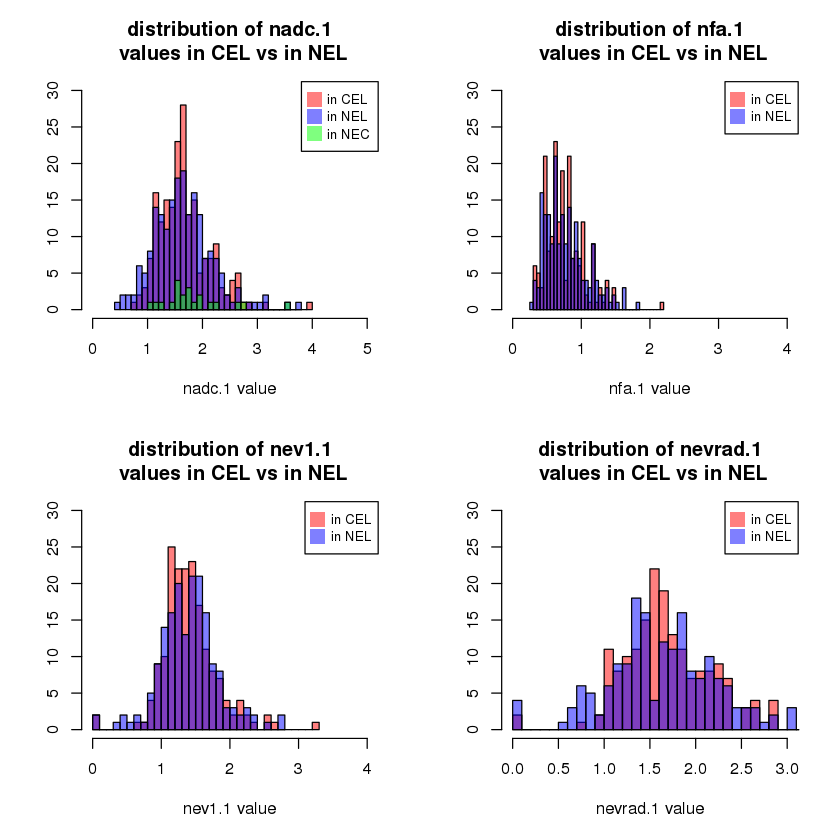

In [12]:
par(mfrow=c(2,2))
hist(recgli[which(recgli$in_CEL==1),]$nadc.1, breaks=35, ylim = c(0, 30),  xlim=c(0,5), col=rgb(1,0,0,0.5), xlab="nadc.1 value", 
     ylab="", main="distribution of nadc.1\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$nadc.1, breaks=35, ylim = c(0, 30),  xlim=c(0,5), col=rgb(0,0,1,0.5), add=T)
hist(recgli[which(recgli$in_NEC==1),]$nadc.1, breaks=35, ylim = c(0, 30),  xlim=c(0,5), col=rgb(0,1,0,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL", "in NEC"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5), rgb(0,1,0,.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$nfa.1, breaks=35, ylim = c(0, 30),  xlim=c(0,4), col=rgb(1,0,0,0.5), xlab="nfa.1 value", 
     ylab="", main="distribution of nfa.1\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$nfa.1, breaks=35, ylim = c(0, 30),  xlim=c(0,4), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$nev1.1, breaks=35, ylim = c(0, 30),  xlim=c(0,4), col=rgb(1,0,0,0.5), xlab="nev1.1 value", 
     ylab="", main="distribution of nev1.1\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$nev1.1, breaks=35, ylim = c(0, 30),  xlim=c(0,4), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

hist(recgli[which(recgli$in_CEL==1),]$nevrad.1, breaks=35, ylim = c(0, 30),  xlim=c(0,3), col=rgb(1,0,0,0.5), xlab="nevrad.1 value", 
     ylab="", main="distribution of nevrad.1\n values in CEL vs in NEL")
hist(recgli[which(recgli$in_NEL==1),]$nevrad.1, breaks=35, ylim = c(0, 30),  xlim=c(0,3), col=rgb(0,0,1,0.5), add=T)
legend("topright", legend=c("in CEL","in NEL"), col=c(rgb(1,0,0,0.5), 
     rgb(0,0,1,0.5)), pt.cex=2, pch=15, cex = .8 )

## 2. Combining diffusion parameters to look at different associations within the GEE model: 

In [32]:
#library(multgee)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
diffu.fit = ordLORgee(formula = tumor_cell_evaluation ~ nadc.1+nfa.1+nev1.1+nevrad.1, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(diffu.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-1.25701,0.64740,-1.94163,0.05218
beta20,-0.56837,0.64110,-0.88655,0.37532
beta30,0.57178,0.63566,0.89949,0.36839
nadc.1,-0.16709,0.51138,-0.32675,0.74386
nfa.1,0.27585,0.51068,0.54016,0.58909
nev1.1,-0.07106,0.84842,-0.08375,0.93325
nevrad.1,0.16085,0.54838,0.29332,0.76928


## 3. Using in_CEL as a covariate in diffu params using GEE 

In [34]:
diffu.cel.fit = anat.fit = ordLORgee(formula = tumor_cell_evaluation ~ nfse+nfl+nt1c+nt1v+in_CEL, link = "logit", 
                      id = t_number, data = recgli, LORstr = "category.exch")
summary(diffu.cel.fit)$coefficients

,Estimate,san.se,san.z,Pr(>|san.z|)
beta10,-2.28341,0.69786,-3.27199,0.00107
beta20,-1.59022,0.68008,-2.33830,0.01937
beta30,-0.44032,0.65896,-0.66819,0.50401
nfse,0.12803,0.12432,1.02989,0.30306
nfl,-0.24963,0.21055,-1.18558,0.23579
nt1c,0.33927,0.22975,1.47666,0.13977
nt1v,1.17103,0.73453,1.59425,0.11088
in_CEL,-0.31248,0.26381,-1.18446,0.23623


## 4. Using RM ANOVA to using imaging chars as dep variable, then TS as independent variable

In [36]:
nadc.rmaov = aov(nadc.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), data=recgli)
summary(nfse.rmaov)

Warning message in aov(nadc.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), :
“Error() model is singular”


Error: t_number
                       Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation   1   0.08  0.0812   0.169  0.682
Residuals             155  74.62  0.4814               

Error: t_number:tumor_cell_evaluation
                      Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation  1  0.015 0.01475   0.064    0.8
Residuals             70 16.041 0.22916               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 147  24.36  0.1657               

In [37]:
nfa.rmaov = aov(nfa.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), data=recgli)
summary(nfse.rmaov)

Warning message in aov(nfa.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), :
“Error() model is singular”


Error: t_number
                       Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation   1  0.001 0.00121   0.007  0.933
Residuals             149 25.056 0.16816               

Error: t_number:tumor_cell_evaluation
                      Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation  1  0.031 0.03084   0.574  0.451
Residuals             68  3.651 0.05368               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 140  6.492 0.04637               

In [38]:
nev1.rmaov = aov(nev1.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), data=recgli)
summary(nfse.rmaov)

Warning message in aov(nev1.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), :
“Error() model is singular”


Error: t_number
                       Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation   1   0.05  0.0476   0.161  0.689
Residuals             142  42.09  0.2964               

Error: t_number:tumor_cell_evaluation
                      Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation  1  0.005 0.00455    0.03  0.863
Residuals             64  9.757 0.15246               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 126  11.23 0.08913               

In [40]:
nevrad.rmaov = aov(nevrad.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), data=recgli)
summary(nfse.rmaov)

Warning message in aov(nevrad.1 ~ tumor_cell_evaluation + Error(t_number/(tumor_cell_evaluation)), :
“Error() model is singular”


Error: t_number
                       Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation   1   0.05  0.0476   0.161  0.689
Residuals             142  42.09  0.2964               

Error: t_number:tumor_cell_evaluation
                      Df Sum Sq Mean Sq F value Pr(>F)
tumor_cell_evaluation  1  0.005 0.00455    0.03  0.863
Residuals             64  9.757 0.15246               

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 126  11.23 0.08913               